# Quality Assessment
Now we follow the steps on the platform to see how reliable the data is.

In [1]:
import pandas as pd

Load our cleaned DataFrames

In [2]:
# orders_cl.csv
# url = "https://drive.google.com/file/d/1Rcw0ez1M0zwNXtiJ6lCbM9wv6JRILc6x/view?usp=sharing"
# path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
# orders_cl = pd.read_csv(path)
#
# # orderlines_cl.csv
# url = "https://drive.google.com/file/d/1rV5gmlmoEG-jX9gSzE3Wec3tsXOSwBPF/view?usp=sharing"
# path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
# orderlines_cl = pd.read_csv(path)
#
# # products_cl.csv
# url = "https://drive.google.com/file/d/1jzEITeNiUGIMiljfp7XnDsh-U2Hyr3M-/view?usp=sharing"
# path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
# products_cl = pd.read_csv(path)

#orders.csv (local)
orders_cl = pd.read_csv("../data/cleaned-data/orders_cl.csv")

#orderlines.csv (local)
orderlines_cl = pd.read_csv("../data/cleaned-data/orderlines_cl.csv")

#products.csv (local)
products_cl = pd.read_csv("../data/cleaned-data/products_cl.csv")

Let's create a copy of our DataFrames, to make sure any of our changes won't affect the original DataFrame. We'll also change the DataFrames from `_cl` to `_qu`, so we can distinguish between the data that has been cleaned, and that which has been quality controlled.

In [3]:
orders_qu = orders_cl.copy()
orderlines_qu = orderlines_cl.copy()
products_qu = products_cl.copy()

In [4]:
orderlines_qu = orderlines_qu.rename(columns={'id_order': 'order_id'})


## 1.&nbsp; Define Pandas display format

In [5]:
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_rows", 1000)

## 2.&nbsp; Exclude unwanted orders

### `orders` - Keep only orders with the state you want to work with
No `shopping cart`, `cancelled` etc...

In [6]:
orders_qu.head()

,Unnamed: 0,order_id,created_date,total_paid,state
0,0,241319,2017-01-02 13:35:40,44.99,Cancelled
1,1,241423,2017-11-06 13:10:02,136.15,Completed
2,2,242832,2017-12-31 17:40:03,15.76,Completed
3,3,243330,2017-02-16 10:59:38,84.98,Completed
4,4,243784,2017-11-24 13:35:19,157.86,Cancelled


Let's look at the make up of `state`.

In [7]:
orders_qu.state.value_counts()

state
Shopping Basket    117809
Completed           46605
Place Order         40883
Pending             14374
Cancelled            7233
Name: count, dtype: int64

Seems like an overwhelming amount of the orders are left in the shopping basket - something we'll have to analyse another time. For this task we're interested in only `completed` orders, so let's filter our DataFrame.

In [8]:
# keep only completed orders
orders_qu = orders_qu.loc[orders_qu.state == "Completed", :]

In [9]:
orders_qu.shape

(46605, 5)

### Keep only the orders that are present in both `orders` and `orderlines`

Let's begin by looking if there's a big difference between the amount of orders present in `orders` and `orderlines`.

In [10]:
orders_qu.order_id.nunique()

46605

In [11]:
orderlines_qu.order_id.nunique()

170213

What a huge difference! We want to make sure that every order_id in `orders` also exists in `orderlines` and vice versa.

Hence we'll perform an inner merge on the two tables using the `order_id`. This will then keep only the `order_id`'s that are present in both tables, which will then help us filter our `_qu` DataFrames once again.

In [12]:
orders_orderlines = orders_qu.merge(orderlines_qu, how="inner", left_on="order_id", right_on="order_id")

In [13]:
# order_ids that are in both tables
order_ids = orders_orderlines["order_id"].unique()

In [14]:
order_ids

array([241423, 242832, 243330, ..., 527074, 527096, 527112])

In [15]:
# keep those ids in orders
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(order_ids), :]

# keep those ids in orderlines
orderlines_qu = orderlines_qu.loc[orderlines_qu["order_id"].isin(order_ids), :]

Let's have a quick check to make sure we're filtering both DataFrames the same. They should both contain the same number of unique `order_id`'s.

In [16]:
orders_qu["order_id"].nunique(), orderlines_qu["order_id"].nunique()

(43064, 43064)

## 3.&nbsp; Exclude orders with unknown products

Let's start by investigating `orderlines` and `products`. We want to make sure that every product in `orderlines` has a matching entry in `products`. All orders with a missing product need to be removed from both `orderlines` and `orders`.

A left-join can help us here:

Joining `orderlines` left on `products` will keep all orderlines, and add the information of `products` on the matching skus. If an sku has been sold in `orderlines`, but the sku does not have an entry in `products` then the product_name will be empty.

In [17]:
orderlines_products = orderlines_qu.merge(products_qu, how="left", on = "sku")[["order_id","sku","name" ]]
orderlines_products.sample(10)

,order_id,sku,name
6550,318695,NTE0013,"AdaptaDrive NewerTech adapter 2.5 ""to 3.5"" SATA"
20039,384606,SPE0191,"Speck Case SmartShell MacBook Pro 15 ""Touch Ba..."
17261,375526,BLM0016,Blue Microphones Yeti USB microphone Gray
28431,417211,OWC0007,OWC Data Doubler Optical Bay adapter Macbook /...
37099,447423,APP2132,"Apple iPad Pro 10.5 ""Wi-Fi + Cellular 256GB Si..."
48895,494920,OTT0104,Clear Case OtterBox Symmetry iPhone 6 / 6S Plu...
5197,314876,KIN0156-A,Open - Kingston SSD Disk 240GB UV400
10107,346394,IFX0137,iFixit Demagnetizer / Magnetizer
36674,446246,CRU0052-2,Crucial memory Mac 16GB (2x8GB) SO-DIMM DDR4 2...
9593,343464,CRU0043-4,Crucial memory Mac 32GB (4x8GB) SO-DIMM DDR3 1...


We can count how many missing products we have.

In [18]:
orderlines_products.name.isna().value_counts()

name
False    55320
True      1394
Name: count, dtype: int64

Looks like the vast majority of products are known.

We can't simply delete the rows containing unknown products. We need to remove the entirety of any order that contains an unknown product to keep a consistent and coherent dataset.

In [19]:
orders_to_delete = orderlines_products.loc[orderlines_products.name.isna(), "order_id"].unique()
orders_to_delete

array([299638, 299706, 299712, ..., 526106, 526122, 526363])

Keep only orders in `orders` and `orderlines`, that are not in this list of corrupted orders.

In [20]:
orders_qu = orders_qu.loc[~orders_qu.order_id.isin(orders_to_delete),:]

In [21]:
orderlines_qu = orderlines_qu.loc[~orderlines_qu.order_id.isin(orders_to_delete),:]

Let's have a quick check to make sure we're filtering both DataFrames the same. They should both contain the same number of unique `order_id`'s.

In [22]:
orders_qu["order_id"].nunique(), orderlines_qu["order_id"].nunique()

(41701, 41701)

## 4.&nbsp; Explore the revenue from different tables

In a consistent and coherent dataset the value of an order should roughly match the sum of all items bought on that order. Let's investigate...

#### Step 1:
Create the `unit_price_total` as `orderlines.unit_price` * `orderlines.product_quantity`

In [23]:
orderlines_qu["unit_price_total"] = orderlines_qu["product_quantity"] * orderlines_qu["unit_price"]

In [24]:
orderlines_qu.tail(10)

,Unnamed: 0,id,order_id,product_id,product_quantity,sku,unit_price,date,unit_price_total
215873,293583,1649440,527035,0,1,APP0498,23.00,2018-03-14 11:41:55,23.00
215874,293584,1649441,527034,0,1,APP0927,13.99,2018-03-14 11:42:01,13.99
215876,293586,1649446,527042,0,1,APP0927,13.99,2018-03-14 11:42:38,13.99
215877,293587,1649447,527035,0,1,APP0698,9.99,2018-03-14 11:42:41,9.99
215886,293596,1649468,525664,0,1,TUC0336,7.93,2018-03-14 11:43:59,7.93
215889,293599,1649474,525664,0,1,TUC0207,16.52,2018-03-14 11:45:05,16.52
215906,293616,1649512,527070,0,2,APP0698,9.99,2018-03-14 11:49:01,19.98
215911,293621,1649522,527074,0,2,APP0698,9.99,2018-03-14 11:49:36,19.98
215932,293644,1649565,527096,0,3,APP0698,9.99,2018-03-14 11:54:35,29.97
215949,293661,1649593,527112,0,1,APP0698,9.99,2018-03-14 11:58:13,9.99


#### Step 2:
Group by `order_id`, summarising by the sum of `unit_price_total`

In [25]:
revenue_per_orders = orderlines_qu.groupby("order_id", as_index=False)["unit_price_total"].sum()
revenue_per_orders.rename(columns={"unit_price_total": "order_price_total"}, inplace=True)
# as_index=False changes the return so that the groupedby column remains a column (not the index)

In [26]:
revenue_per_orders

,order_id,order_price_total
0,241423,129.16
1,242832,10.77
2,243330,77.99
3,245275,149.00
4,245595,105.98
...,...,...
41696,527042,13.99
41697,527070,19.98
41698,527074,19.98
41699,527096,29.97


### What is the average difference between `total_paid` and `order_price_total`?

Let's merge our grouped `orderlines` table with the `orders` table, so we can calculate the differences in prices.

In [27]:
avg_diff_paid = orders_qu.merge(revenue_per_orders, left_on="order_id", right_on="order_id")

In [28]:
avg_diff_paid["difference"] = avg_diff_paid["total_paid"] - avg_diff_paid["order_price_total"]
avg_diff_paid.head(10)

,Unnamed: 0,order_id,created_date,total_paid,state,order_price_total,difference
0,1,241423,2017-11-06 13:10:02,136.15,Completed,129.16,6.99
1,2,242832,2017-12-31 17:40:03,15.76,Completed,10.77,4.99
2,3,243330,2017-02-16 10:59:38,84.98,Completed,77.99,6.99
3,5,245275,2017-06-28 11:35:37,149.00,Completed,149.00,0.00
4,6,245595,2017-01-21 12:52:47,112.97,Completed,105.98,6.99
5,10,246405,2017-11-24 10:01:27,407.96,Completed,275.75,132.21
6,11,247524,2018-01-09 14:21:34,167.98,Completed,162.99,4.99
7,12,247643,2017-05-26 11:50:35,153.54,Completed,153.54,0.00
8,13,250275,2017-11-19 22:34:54,54.99,Completed,51.00,3.99
9,14,251302,2017-05-10 12:27:33,140.99,Completed,140.99,0.00


In [29]:
avg_diff_paid['difference'].min()

np.float64(-165.0)

Now that we know the difference for each order, we can compute the average.

In [30]:
avg_diff_paid.difference.mean().round(2)

np.float64(4.47)

### What is the distribution of these differences?

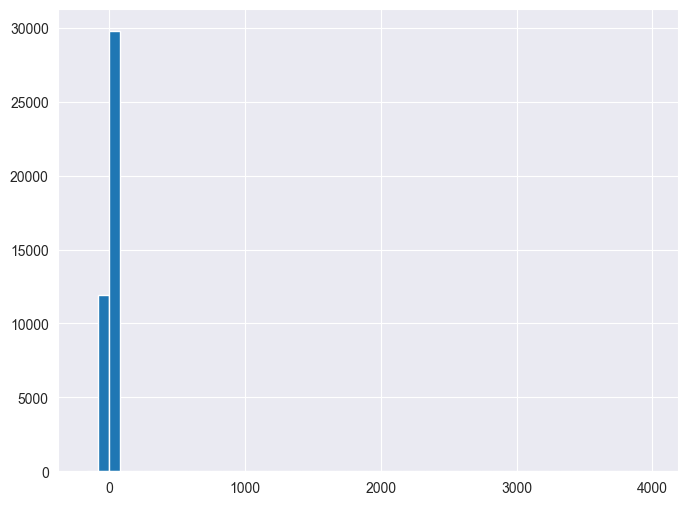

In [31]:
avg_diff_paid.difference.hist(bins= 50, figsize=(8,6));

Looking at the spread of the data above, some of the difference must be due to corruption. Let's use `.describe()` to investigate the distribution further.

In [32]:
avg_diff_paid.difference.describe()

count   41701.00
mean        4.47
std        26.05
min      -165.00
25%         0.00
50%         4.99
75%         6.99
max      3984.99
Name: difference, dtype: float64

We can see from the our quartiles (0.00, 4.99, 6.99) that most of our data fits an expected pattern - free, 4.99, and 6.99 all seem like reasonable prices to assume as postage. However, look at the min and the max values, -165.00 and 3984.99, this can only occur due to corrupted data.

### Can all the differences be explained by shipping costs? If not, what are other plausible explanations?

What reasons have we come up with to explain the difference?

### If there are differences that we can’t explain: what should we do with these orders?
There's a rule of thumb, that anything:
+ lower than the 25% quartile - (1.5 x interquartile range), or
+ higher than the 75% quartile + (1.5 x interquartile range)

is an outlier. Let's use this rule to try and exclude any corrupted data.

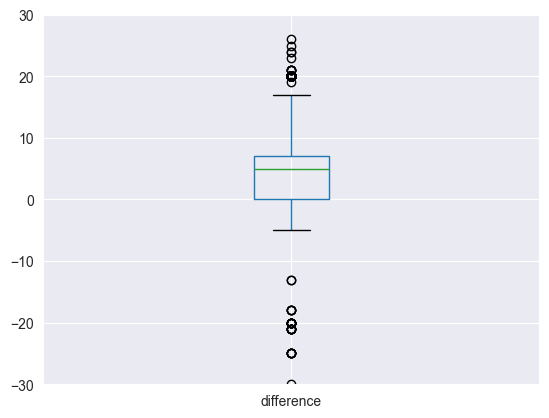

In [33]:
# We know this rule from the boxplot
import matplotlib.pyplot as plt

ax = avg_diff_paid.boxplot("difference");
ax.set_ylim(-30, +30)
plt.show()

In [34]:
# calculate the quartiles
Q1 = avg_diff_paid["difference"].quantile(0.25)
Q3 = avg_diff_paid["difference"].quantile(0.75)

Q1, Q3

(np.float64(0.0), np.float64(6.989999999999981))

In [35]:
# calculate the interquartile range
IQR = Q3-Q1
IQR

np.float64(6.989999999999981)

In [36]:
# lower boundary
Q1 - 1.5*IQR

np.float64(-10.484999999999971)

In [37]:
# upper boundary
Q3 + 1.5*IQR

np.float64(17.47499999999995)

In [38]:
# filter the DataFrame to include only "non-outliers"
orders_avg_diff_paid_no_outliers = avg_diff_paid.loc[
    (avg_diff_paid["difference"] >= (Q1 - 1.5*IQR))
    &
    (avg_diff_paid["difference"] <= (Q3 + 1.5*IQR))
    ,
    :]

Let's look at the distribution again to see the effect of removing the outliers.

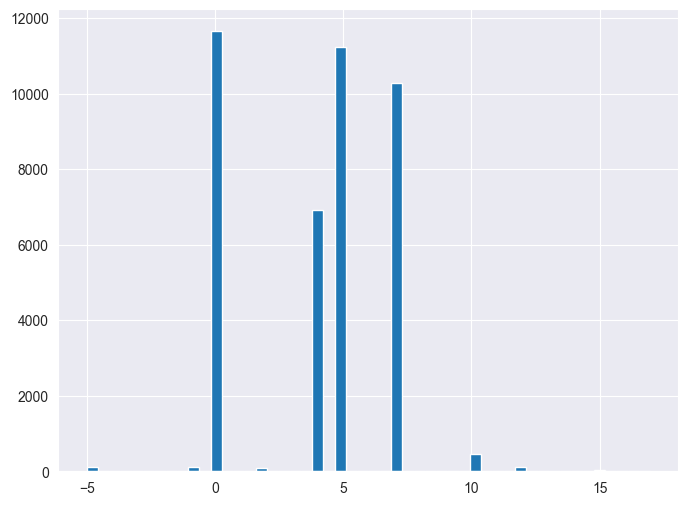

In [39]:
orders_avg_diff_paid_no_outliers.difference.hist(bins= 50, figsize=(8,6));

<Axes: >

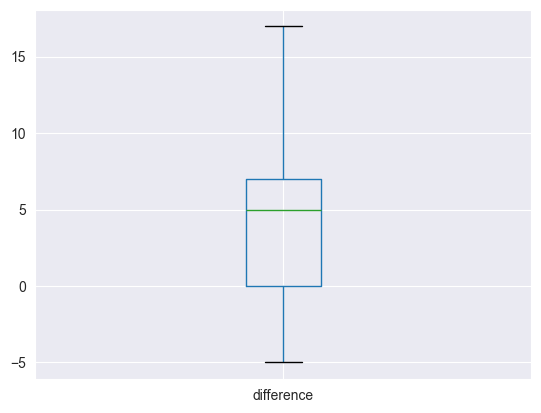

In [40]:
orders_avg_diff_paid_no_outliers.boxplot("difference")

This looks much more like what we would expect: a small difference, but nothing extreme.

Now we need to remove these orders with extreme differences from our `orders_lines_merged` DataFrame.

In [41]:
normal_diff_list = orders_avg_diff_paid_no_outliers["order_id"]

In [42]:
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(normal_diff_list), :]
orderlines_qu = orderlines_qu.loc[orderlines_qu["order_id"].isin(normal_diff_list), :]
revenue_per_orders = revenue_per_orders.loc[revenue_per_orders["order_id"].isin(normal_diff_list), :]

In [43]:
orders_qu["order_id"].nunique(), orderlines_qu["order_id"].nunique()

(40985, 40985)

In [44]:
orders_avg_diff_paid_no_outliers['difference'].min()

np.float64(-5.000000000000114)

## 5.&nbsp; Now , the dataset is more confident

In [45]:
# from google.colab import files
#
# orders_qu.to_csv("orders_qu.csv", index=False)
# files.download("orders_qu.csv")
#
# orderlines_qu.to_csv("orderlines_qu.csv", index=False)
# files.download("orderlines_qu.csv")

orders_qu.to_csv("../data/quality-assessed-data/orders_qu.csv")
orderlines_qu.to_csv("../data/quality-assessed-data/orderlines_qu.csv")
products_qu.to_csv("../data/quality-assessed-data/products_qu.csv")
revenue_per_orders.to_csv("../data/quality-assessed-data/revenue_per_orders.csv")
orders_avg_diff_paid_no_outliers.to_csv("../data/quality-assessed-data/orders_avg_diff_paid_no_outliers.csv")